In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


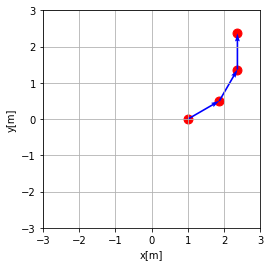

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes,[-3,3],[-3,3])

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_SPACE = 0.1 # [m / step]
X_train = []
for i in range(DATA_SIZE):
    d = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_SPACE+1),xp.random.rand()*(2*xp.pi/3)-xp.pi/3) # -60 ~ 60 deg
    d_es,_ = data.get_evenly_spaced_points(d,DATA_SPACE)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    #d_xy_fl = xp.ravel(d_xy[0:DATA_WAYPOINTS])
    X_train.append(d_xy)
print(len(X_train))
print(X_train[0])

1000
[[ 0.12240164 -0.00294836 -1.61896221]
 [ 0.24451937 -0.01178661 -1.6671281 ]
 [ 0.36606993 -0.02649424 -1.71529398]
 [ 0.4867714  -0.04703714 -1.76345986]
 [ 0.60634379 -0.07336766 -1.81162575]
 [ 0.72450977 -0.10542473 -1.85979163]
 [ 0.84099525 -0.14313398 -1.90795752]
 [ 0.95553003 -0.18640796 -1.9561234 ]
 [ 1.06784846 -0.23514629 -2.00428929]
 [ 1.17769001 -0.28923592 -2.05245517]]


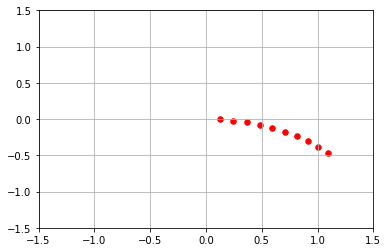

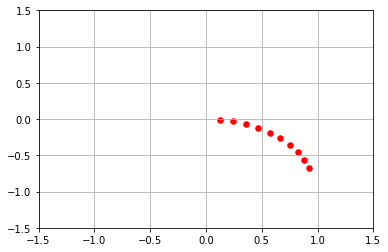

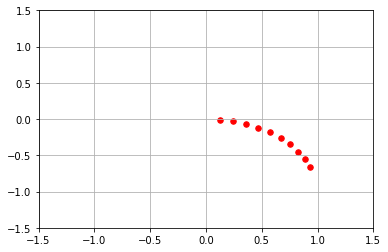

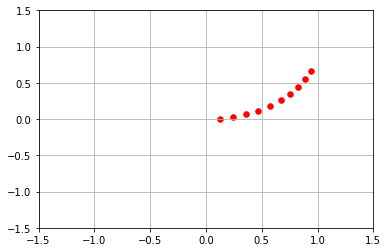

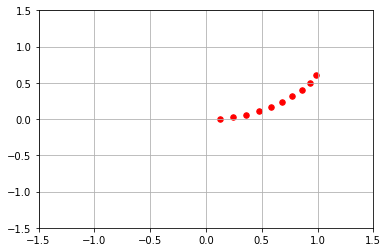

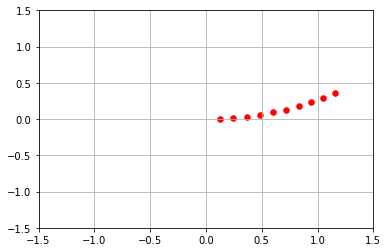

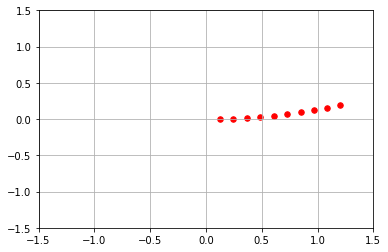

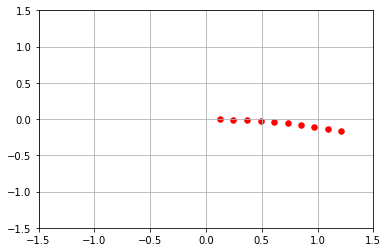

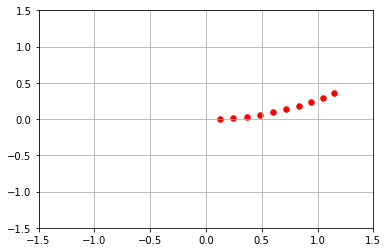

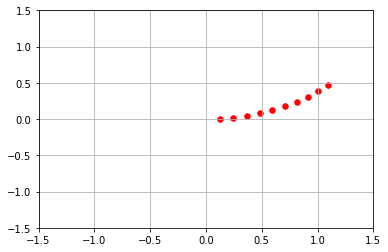

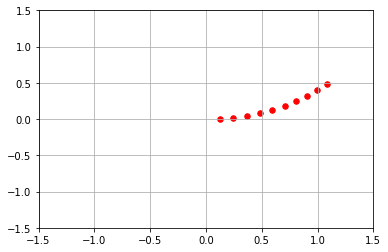

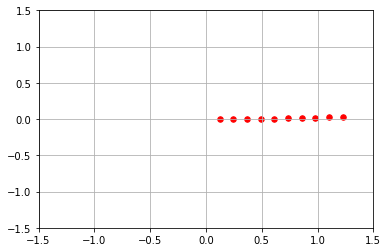

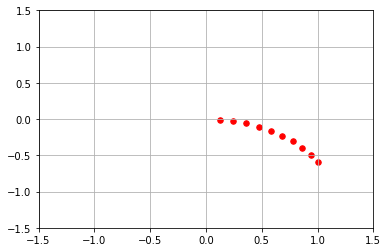

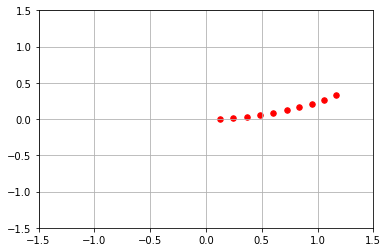

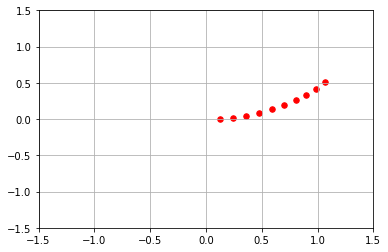

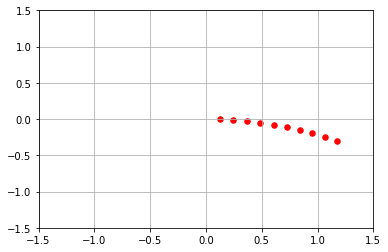

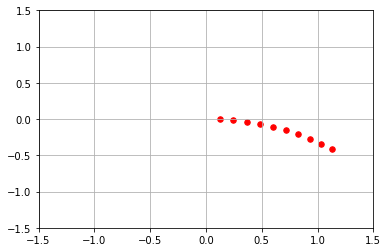

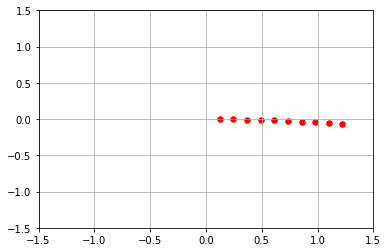

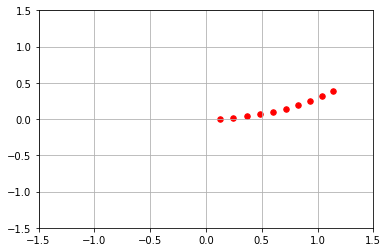

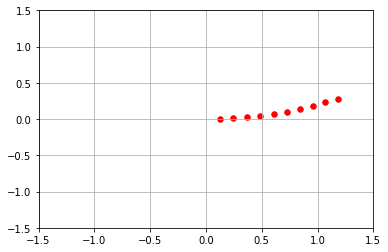

In [6]:
# plot data
p = X_train
if(settings.gpu_index >= 0):
    p = xp.asnumpy(p)

for num in range(20):
    rand_idx = int(np.random.rand() * len(X_train))
    plt.scatter(p[rand_idx][:,0], p[rand_idx][:,1],c="red",edgecolor="red",s=30,marker="o")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid()
    plt.show()

In [7]:
# loss
def error_squares(predict,groundtruth):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = groundtruth * w
    p = predict * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

In [8]:
# training
def train(model,X,epoch=10):
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        model.to_gpu(settings.gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    ep = 0
    while ep < epoch:
        for itr in range(len(X)):
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y = model(x)
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
            #print(y)
            #print(pad)
            y_pad = F.concat((y,pad),axis=2)
            #print(y_pad)
            y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
            #print(y_pad)
            
            # loss
            z_true = X[itr][:]
            z = y_pad[0,0]
            e = error_squares(z,z_true[0])
            model.cleargrads()
            e.backward()
            opt.update()
            for step in range(1,DATA_NUM_STEP):
                z = oplus(z,y_pad[0,step])
                e = error_squares(z,z_true[step])
                model.cleargrads()
                e.backward()
                opt.update()
        ep = ep + 1
        print('epoch',ep,'loss',e)
    return model

In [9]:
EPOCH = 10
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
model = train(model,X_train,epoch=EPOCH)
print('finished')

epoch 1 loss variable(0.06328815)
epoch 2 loss variable(0.05491238)
epoch 3 loss variable(0.00720262)
epoch 4 loss variable(0.04037232)
epoch 5 loss variable(0.05371305)
epoch 6 loss variable(0.03599448)
epoch 7 loss variable(0.06547303)
epoch 8 loss variable(0.05196086)
epoch 9 loss variable(0.04213921)
epoch 10 loss variable(0.05217924)
finished


[[ 0.12224367  0.0061373  -1.47046969]
 [ 0.24325793  0.02448746 -1.37014306]
 [ 0.36182575  0.05486595 -1.26981642]
 [ 0.47675469  0.09696725 -1.16948979]
 [ 0.58688891  0.15036794 -1.06916315]
 [ 0.69112079  0.21453097 -0.96883652]
 [ 0.78840207  0.28881107 -0.86850988]
 [ 0.8777544   0.37246118 -0.76818325]
 [ 0.95827916  0.46464004 -0.66785661]
 [ 1.02916652  0.56442062 -0.56752998]]
variable([[[0.12508897 0.         0.20545205]
           [0.12758683 0.         0.10528954]
           [0.12750456 0.         0.03947411]
           [0.1269285  0.         0.14314458]
           [0.1289074  0.         0.17267202]
           [0.13113123 0.         0.05202812]
           [0.12939575 0.         0.05051388]
           [0.12899211 0.         0.2026284 ]
           [0.1290862  0.         0.09684463]
           [0.1259225  0.         0.        ]]])
loss: variable(0.00676478)
loss: variable(0.00690875)
loss: variable(0.01394615)
loss: variable(0.01807168)
loss: variable(0.02585159)
loss: varia

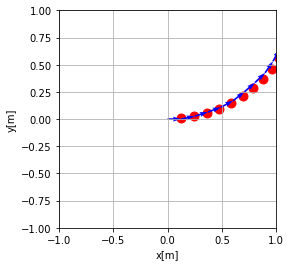

In [10]:
x_path = data.make_arc_path_2(int(DATA_NUM_WAYPOINTS*DATA_SPACE+1),xp.random.rand()*(2*xp.pi/3)-xp.pi/3) # -60 ~ 60 deg
x_path_es,_ = data.get_evenly_spaced_points(x_path,DATA_SPACE)
x_test = x_path_es[0:DATA_NUM_WAYPOINTS]
x = xp.ravel(x_test[:,0:2])
x = Variable(xp.array([x],dtype=xp.float32))
y = model(x)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
y_pad = F.concat((y,pad),axis=2)
y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
print(x_test)
print(y_pad)
# loss
z_true = x_test
z = y_pad[0,0]
e = error_squares(z,z_true[0])
print('loss:',e)
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    e = error_squares(z,z_true[step])
    print('loss:',e)
    Z = xp.vstack((Z,z.data))
print(Z)
print(z_true.shape)
plot_path(Z,z_true,[-1,1],[-1,1])

In [11]:
serializers.save_npz('tmp.npz', model)